In [1]:
from dask.distributed import Client
from dask.diagnostics import ProgressBar
import dask
import dask.delayed
import numpy as np
import xarray as xr
import geopandas as gpd

from matplotlib import pyplot as plt
from rasterio import RasterioIOError
from tqdm.autonotebook import tqdm
%matplotlib inline
import sklearn.linear_model
import skimage.morphology
import skimage.segmentation
import skimage.future
#import richdem as rd
import scipy.ndimage
import dask
import math
import scipy.sparse
import shapefile
import shapely
import rioxarray
import cartopy as crt
from shapely.geometry import mapping
#import networkx as nx
import matplotlib
import pandas as pd

#import cv2
import gcsfs
import json
import h5py

import cartopy.feature as features

<ipython-input-1-43627b35f00a>:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import os
import dask
from dask_gateway import Gateway
from dask.distributed import Client
import dask_gateway
import dask.array as da

## Open Cluster

In [3]:
# get the dask-gateway version
dask_gateway.__version__

# show the default dask-gateway settings
dask.config.config['gateway']

# show the current default image to be started on workers
os.environ['JUPYTER_IMAGE_SPEC']

# use the same GDAL environment settings as we did for the single COG case
env = dict(GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR', 
           AWS_NO_SIGN_REQUEST='YES',
           GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
           GDAL_SWATH_SIZE='200000000',
           VSI_CURL_CACHE_SIZE='200000000')
os.environ.update(env)

gateway = Gateway()
#options = gateway.cluster_options()
#options.environment = env 
#cluster = gateway.new_cluster(options)
#cluster.scale(4) # let's get the same number of "workers" as our previous LocalCluster examples
cluster = gateway.new_cluster()

gateway.list_clusters()

[ClusterReport<name=prod.39a2e873ad5944878cb4313f97c36c92, status=RUNNING>]

In [4]:
gateway.list_clusters()

[ClusterReport<name=prod.39a2e873ad5944878cb4313f97c36c92, status=RUNNING>]

In [5]:
# connect a client
# the distributed client is used for running parallel tasks with Dask
client = Client(cluster)

In [6]:
client

Client Scheduler: gateway://traefik-gcp-uscentral1b-prod-dask-gateway.prod:80/prod.39a2e873ad5944878cb4313f97c36c92 Dashboard: /services/dask-gateway/clusters/prod.39a2e873ad5944878cb4313f97c36c92/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [7]:
cluster.scale(8)

In [8]:
cd

/home/jovyan


In [9]:
import datetime

In [10]:
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/RACMO/SM'))


<ipython-input-10-0af543cf629a>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/RACMO/SM'))


In [11]:
SM_original = xr.open_zarr(mapper, decode_times=True,)

In [12]:
pTsg = xr.open_zarr(gcs.get_mapper('gs://ldeo-glaciology/RACMO/pTsg.zarr'))


In [13]:
import pyproj

In [14]:
datetimes = pd.to_datetime(SM_original.time.values-719529, unit='D')

In [15]:
SM_summer_index = np.argwhere(np.isin(datetimes.month,[12,1,2]))

In [16]:
SM = SM_original.assign(datetime = datetimes)

In [17]:
def replace_negatives(data):
    data_new = data
    data_new.data[data.data<0]=0
    return(data_new)

In [18]:
SM_new = SM.SM_data.chunk({'lat':-1,'lon':-1}).map_blocks(replace_negatives)

In [19]:
SM_sum = SM_new.sum(dim='time')

In [20]:
SM_sum = SM_sum.squeeze()

SM_sum

<xarray.DataArray 'SM_data' (lat: 240, lon: 262)>
dask.array<getitem, shape=(240, 262), dtype=float64, chunksize=(240, 262), chunktype=numpy.ndarray>
Coordinates:
    height   float64 0.0
Dimensions without coordinates: lat, lon

In [21]:
cd

/home/jovyan


In [22]:
cd REMAWaterRouting/

/home/jovyan/REMAWaterRouting


In [23]:
#read in the shapefiles of ice shelf grounding lines
IS = gpd.read_file('Functions/IceShelf_Antarctica_v02/IceShelf_Antarctica_v02.shp') 

#select an ice shelf,i.e the Amery Ice Shelf in east Antarctica
Amery = IS[IS.NAME=='Amery']

In [24]:
ice_shelf = 'Amery'

In [25]:
cd

/home/jovyan


In [26]:
with open('ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)
gcs = gcsfs.GCSFileSystem(token=token)
mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))

<ipython-input-26-5ffcf5648572>:4: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mapper = gcs.get_mapper(np.str('gs://ldeo-glaciology/REMA/processed/'+ice_shelf))


In [27]:
processed = xr.open_zarr(mapper)
if ice_shelf=='Baudouin': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
    processed = processed.apply(np.fliplr)
    processed = processed.apply(np.flipud)
if ice_shelf=='Nivl': #Baudouin and Nivlisen are upside down
    processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
  #  processed = processed.apply(np.fliplr)
  #  processed = processed.apply(np.flipud)
if ice_shelf=='Riiser': #Riiser is sideways
    processed = processed.transpose()
    
if ice_shelf=='LarsenC': #LarsenC is sideways
    processed = processed.transpose()

In [28]:
processed.attrs.update({'crs':'+init=epsg:3031'})
processed.attrs.update({'transform': (32.0, 0.0, 1600000.0, 0.0, -32.0, 800000.0)})
processed.attrs.update({'res': (32.0, 32.0)})
processed.attrs.update({'is_tiled': 1})
processed.attrs.update({'nodatavals': (-9999.0,)})
processed.attrs.update({'scales': (1.0,)})
processed.attrs.update({'offsets': (0.0,)})

In [29]:
processed.DB_filled.shape

(18750, 6250)

In [30]:
processed =  processed.chunk({'x': 2000,'y':2000})
cellsize = processed.res[1]

In [31]:
X = processed.x.values
Y = processed.y.values
mesh_X, mesh_Y = np.meshgrid(X,Y)

In [32]:

# define the rotated pole coordinate reference system (crs)
crs_rotatedPole = pyproj.CRS.from_proj4(pTsg.rotated_pole.attrs['proj4_params'])
# define the WGS84 crs (the standard one used widely)
crs_3031 = pyproj.CRS.from_proj4(IS.crs.to_proj4())
# define the 'transformer' object, which can convert from WGS84 to the rotated pole RACMO crs.
tr = pyproj.Transformer.from_crs(crs_3031, crs_rotatedPole)

<ipython-input-32-3c0975c33758>:4: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  crs_3031 = pyproj.CRS.from_proj4(IS.crs.to_proj4())


In [33]:
lon,lat = tr.transform(mesh_Y,mesh_X)

In [34]:
#X, Y = np.array([y for y in exterior_ring.coords]).transpose()

#lon,lat = tr.transform(X,Y)
points = np.transpose([lat,lon])

In [35]:
cd

/home/jovyan


In [36]:
crs_rotatedPole_dict = crs_rotatedPole.to_dict()

/srv/conda/envs/notebook/lib/python3.8/site-packages/pyproj/crs/crs.py:543: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj_string = self.to_proj4()


In [37]:
crs_rotatedPole_dict['o_lon_p']=0

In [47]:
SM_new.rio.write_crs(crs_rotatedPole_dict, inplace=True)

<xarray.DataArray 'SM_data' (time: 14610, height: 1, lat: 240, lon: 262)>
dask.array<replace_negatives-65bc97bb75100cef114576d4bebc2c82-<this, shape=(14610, 1, 240, 262), dtype=float64, chunksize=(914, 1, 240, 262), chunktype=numpy.ndarray>
Coordinates:
  * height       (height) float64 0.0
  * time         (time) float64 7.228e+05 7.228e+05 ... 7.374e+05 7.374e+05
    spatial_ref  int64 0
Dimensions without coordinates: lat, lon
Attributes:
    grid_mapping:  spatial_ref

In [44]:
xi = np.transpose([lat.ravel(),lon.ravel()])

In [38]:
SM_lat = SM.lat.data.ravel().compute()

In [39]:
SM_lon = SM.lon.data.ravel().compute()

In [40]:
points = np.transpose([SM_lat,SM_lon])

In [41]:
cluster.scale(8)

In [42]:
data = SM_sum.data

In [45]:
SM_interp = scipy.interpolate.griddata(points,data.ravel(),xi,'nearest')

In [46]:
SM_interp = SM_interp.reshape(processed.DB_filled.shape)

In [57]:
SM_volume = SM_interp*0.001*(60*60*24)/(len(SM_new.time)/365.25)

In [58]:
SM_xr = xr.zeros_like(processed.DB_filled)

In [59]:
SM_xr.data = SM_volume

<AxesSubplot:xlabel='y', ylabel='x'>

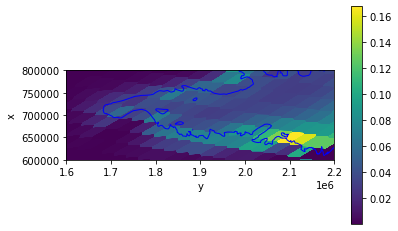

In [60]:
fig, ax = plt.subplots()
SM_xr.transpose().coarsen(x=10,y=10).mean().plot(ax=ax)
Amery.geometry.plot(facecolor='None', edgecolor='b',ax=ax)

In [61]:
cluster.shutdown()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
Exception in callback None()
handle: <Handle cancelled>
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/site-packages/tornado/iostream.py", line 1391, in _do_ssl_handshake
    self.socket.do_handshake()
  File "/srv/conda/envs/notebook/lib/python3.8/ssl.py", line 1309, in do_handshake
    self._sslobj.do_handshake()
ssl.SSLCertVerificationError: [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate (_ssl.c:1124)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/srv/conda/envs/notebook/lib/p